In [1]:
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from skimage.transform import resize
from skimage.io import imsave
from skimage.io import imread
import numpy as np

In [2]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv3D, MaxPooling3D, Conv3DTranspose, AveragePooling3D, ZeroPadding3D
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras import backend as K
from keras.regularizers import l2
from keras.utils import plot_model

Using TensorFlow backend.


In [3]:
def deform(array, factor, axis):
    stretched = np.repeat(array, np.ceil(factor), axis=axis)
    indices = np.linspace(0, stretched.shape[axis] - 1, int(array.shape[axis] * factor))
    indices = np.rint(indices).astype(int)
    return np.take(stretched, indices, axis=axis)

In [4]:
data_path = './'
project_name = '3D-Unet'
img_depth = 32
img_rows = 64
img_cols = 64
smooth = 1.

In [5]:
K.set_image_data_format('channels_last')

In [20]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def get_unet():
    inputs = Input((img_depth, img_rows, img_cols, 1))
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5), conv4], axis=4)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6), conv3], axis=4)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv7), conv2], axis=4)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv8), conv1], axis=4)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv9)


    model = Model(inputs=[inputs], outputs=[conv10])

    model.summary()
    #plot_model(model, to_file='model.png')

    model.compile(optimizer=Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.000000199), loss=dice_coef_loss, metrics=['accuracy'])

    return model

In [60]:
from glob import glob
def preprocess_data(np_array, img_depth, img_rows, img_cols):
    """Return the data preprocessed"""
    data = np_array.copy()
    # Depth first is required
    data = np.transpose(data)
    # Rescale the data
    data = deform(data, img_depth/data.shape[0], axis=0)
    data = deform(data, img_rows/data.shape[1], axis=1)
    data = deform(data, img_cols/data.shape[2], axis=2)
    return data
    
def load_dataset_one_sequence(filename, num_images=10, img_depth=32, img_rows=64, img_cols=64):
    """Return a 4D array of images with dimensions (t,z,x,y)"""
    listArray = []
    for i in range(num_images):
        img = np.load(filename)['arr_0'][i]
        img = preprocess_data(img, img_depth, img_rows, img_cols)
        listArray.append(img)
    return np.array(listArray)
"""
def load_dataset_all_sequences(folder, num_images=10, img_depth=32, img_rows=64, img_cols=64):
    Return a 4D array of images with dimensions (t,z,x,z)
    img_counter = 0    
    listArray = []
    for fle in glob("./data/*.npz"):
"""        

In [61]:
def train():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    
    images = load_dataset_one_sequence('20190708_SJR5.2_w3_s2_color1.npz')
    labels = load_dataset_one_sequence('20190708_SJR5.2_w3_s2_ground_truth.npz')
    print(images.shape)
    
    imgs_train = np.expand_dims(images, axis=4)
    imgs_mask_train = np.expand_dims(labels, axis=4)
    
    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_train = imgs_train.astype('float32')

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    weight_dir = 'weights'
    if not os.path.exists(weight_dir):
        os.mkdir(weight_dir)
    model_checkpoint = ModelCheckpoint(os.path.join(weight_dir, project_name + '.h5'), monitor='val_loss', save_best_only=True)

    log_dir = 'logs'
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    csv_logger = CSVLogger(os.path.join(log_dir,  project_name + '.txt'), separator=',', append=False)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)

    model.fit(imgs_train, imgs_mask_train, batch_size=4, epochs=100, verbose=1, shuffle=True, validation_split=0.10, callbacks=[model_checkpoint, csv_logger])

    print('-'*30)
    print('Training finished')
    print('-'*30)

In [62]:
def predict():



    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    

    a = np.load('20190708_SJR5.2_w3_s2_color1.npz')['arr_0'][0]
    a = np.transpose(a)
    a = np.resize(a, (32,64,64))
    A = np.array([a,a,a,a])
    imgs_train = np.expand_dims(A, axis=4)
    imgs_test = imgs_train.astype('float32')
    

    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)

    model = get_unet()
    weight_dir = 'weights'
    if not os.path.exists(weight_dir):
        os.mkdir(weight_dir)
    model.load_weights(os.path.join(weight_dir, project_name + '.h5'))

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)

    imgs_mask_test = model.predict(imgs_test, batch_size=1, verbose=1)

    npy_mask_dir = 'test_mask_npy'
    if not os.path.exists(npy_mask_dir):
        os.mkdir(npy_mask_dir)

    np.save(os.path.join(npy_mask_dir, project_name + '_mask.npy'), imgs_mask_test)

    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)

    print('-'*30)
    print('Prediction finished')
    print('-'*30)

In [63]:
train()

------------------------------
Loading and preprocessing train data...
------------------------------
(10, 32, 64, 64)
------------------------------
Creating and compiling model...
------------------------------
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 64, 64, 1 0                                            
__________________________________________________________________________________________________
conv3d_134 (Conv3D)             (None, 32, 64, 64, 3 896         input_8[0][0]                    
__________________________________________________________________________________________________
conv3d_135 (Conv3D)             (None, 32, 64, 64, 3 27680       conv3d_134[0][0]                 
_____________________________________________________________________________

9/9 [==============================] - 32s 4s/step - loss: -0.0183 - accuracy: 0.0263 - val_loss: -0.0189 - val_accuracy: 0.0270
Epoch 6/100
9/9 [==============================] - 31s 3s/step - loss: -0.0183 - accuracy: 0.0268 - val_loss: -0.0189 - val_accuracy: 0.0272
Epoch 7/100
9/9 [==============================] - 31s 3s/step - loss: -0.0183 - accuracy: 0.0270 - val_loss: -0.0189 - val_accuracy: 0.0274
Epoch 8/100
9/9 [==============================] - 31s 3s/step - loss: -0.0184 - accuracy: 0.0271 - val_loss: -0.0189 - val_accuracy: 0.0276
Epoch 9/100
9/9 [==============================] - 30s 3s/step - loss: -0.0184 - accuracy: 0.0274 - val_loss: -0.0190 - val_accuracy: 0.0279
Epoch 10/100
4/9 [============>.................] - ETA: 16s - loss: -0.0184 - accuracy: 0.0276

KeyboardInterrupt: 

In [44]:
predict()

------------------------------
Loading and preprocessing test data...
------------------------------
------------------------------
Loading saved weights...
------------------------------
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 64, 64, 1 0                                            
__________________________________________________________________________________________________
conv3d_58 (Conv3D)              (None, 32, 64, 64, 3 896         input_4[0][0]                    
__________________________________________________________________________________________________
conv3d_59 (Conv3D)              (None, 32, 64, 64, 3 27680       conv3d_58[0][0]                  
__________________________________________________________________________________________________
max

In [25]:
c = np.load('test_mask_npy/3D-Unet_mask.npy')

In [26]:
c = c[2,:,:,:,0]
c.shape

(32, 64, 64)

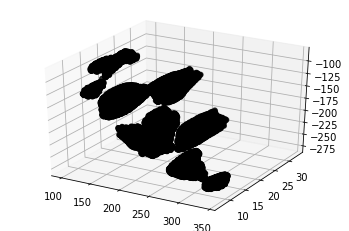

In [11]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

b = np.load('20190708_SJR5.2_w3_s2_ground_truth.npz')['arr_0'][0]
z,x,y = b.nonzero()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'black')
plt.savefig("demo.png")

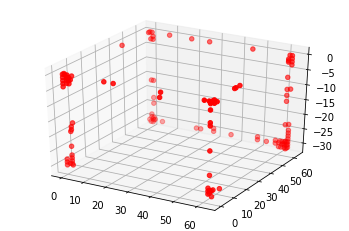

In [36]:
c_filtered = c.copy()
c_filtered[np.where(c_filtered< 0.01)] = 0
z,x,y = c_filtered.nonzero()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'red')
plt.savefig("demo.png")

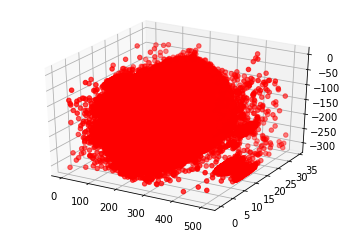

In [15]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

a = np.load('20190708_SJR5.2_w3_s2_color1.npz')['arr_0'][0]
a_filtered = a.copy()
a_filtered[np.where(a_filtered< 254)] = 0
z,x,y = a_filtered.nonzero()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'red')
plt.savefig("demo.png")

In [19]:
print(a_filtered==255)

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal